## Code for table cleaning and transition matrix extraction


First of all we need to extract and clean our data table

## Data loading

As usual we start by importing the modules we need and loading some
`example data <eyelink-dataset>`: eye-tracking data recorded from SR research's
``'.asc'`` file format, and EEG data recorded from EGI's ``'.mff'`` file format. We'll
pass ``create_annotations=["blinks"]`` to :func:`~mne.io.read_raw_eyelink` so that
only blinks annotations are created (by default, annotations are created for blinks,
saccades, fixations, and experiment messages).



In [3]:
import mne
from mne.datasets.eyelink import data_path
from mne.preprocessing.eyetracking import read_eyelink_calibration
from pathlib import Path
import pandas as pd 
import numpy as np
from pyplr.plr import PLR
from pyplr import graphing
from pyplr import preproc
from pyplr import utils

et_fpath = Path('data') / "001_2023_07_12_11_15.asc"
df_list=[]
df_list_raw=[]
df_list_params_assets=[]
df_list_params_suprise=[]
subject='hola'

raw_et = mne.io.read_raw_eyelink(et_fpath, preload=True, create_annotations=['blinks','messages'])


Loading z:\lab\escritorio\projects\pupil_labs\analysis\pupil_labs_analysis\analysis\pupillometry\eye_link\data\001_2023_07_12_11_15.asc
Pixel coordinate data detected.Pass `scalings=dict(eyegaze=1e3)` when using plot method to make traces more legible.
Pupil-size area detected.
There are 69 recording blocks in this file. Times between  blocks will be annotated with BAD_ACQ_SKIP.


The info structure of the eye-tracking data 

In [2]:
SAMPLE_RATE=raw_et.info['sfreq']
raw_et.info

<Info | 7 non-empty values
 bads: []
 ch_names: xpos_left, ypos_left, pupil_left, xpos_right, ypos_right, ...
 chs: 4 Eye-tracking (Gaze position), 2 Eye-tracking (Pupil size)
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2023-07-12 00:20:15 UTC
 nchan: 6
 projs: []
 sfreq: 500.0 Hz
>

## Checking the calibration

EyeLink ``.asc`` files can also include calibration information.
MNE-Python can load and visualize those eye-tracking calibrations, which
is a useful first step in assessing the quality of the eye-tracking data.
:func:`~mne.preprocessing.eyetracking.read_eyelink_calibration`
will return a list of :class:`~mne.preprocessing.eyetracking.Calibration` instances,
one for each calibration. We can index that list to access a specific calibration.

In [3]:
cals = read_eyelink_calibration(et_fpath)
print(f"number of calibrations: {len(cals)}")
first_cal = cals[0]  # let's access the first (and only in this case) calibration
print(first_cal)

Reading calibration data from z:\lab\escritorio\projects\pupil_labs\analysis\pupil_labs_analysis\analysis\pupillometry\eye_link\data\001_2023_07_12_11_15.asc
number of calibrations: 2
Calibration |
  onset: -16.515 seconds
  model: HV9
  eye: left
  average error: 0.5 degrees
  max error: 1.0 degrees
  screen size: None meters
  screen distance: None meters
  screen resolution: None pixels



Calibrations have dict-like attribute access; in addition to the attributes shown in
the output above, additional attributes are ``'positions'`` (the x and y coordinates
of each calibration point), ``'gaze'`` (the x and y coordinates of the actual gaze
position to each calibration point), and ``'offsets'`` (the offset in visual degrees
between the calibration position and the actual gaze position for each calibration
point). Below is an example of how to access these data:

In [1]:
print(f"offset of the first calibration point: {first_cal['offsets'][0]}")
print(f"offset for each calibration point: {first_cal['offsets']}")
print(f"x-coordinate for each calibration point: {first_cal['positions'].T[0]}")

NameError: name 'first_cal' is not defined

Let's plot the calibration to get a better look. Below we see the location that each
calibration point was displayed (gray dots), the positions of the actual gaze (red),
and the offsets (in visual degrees) between the calibration position and the actual
gaze position of each calibration point.


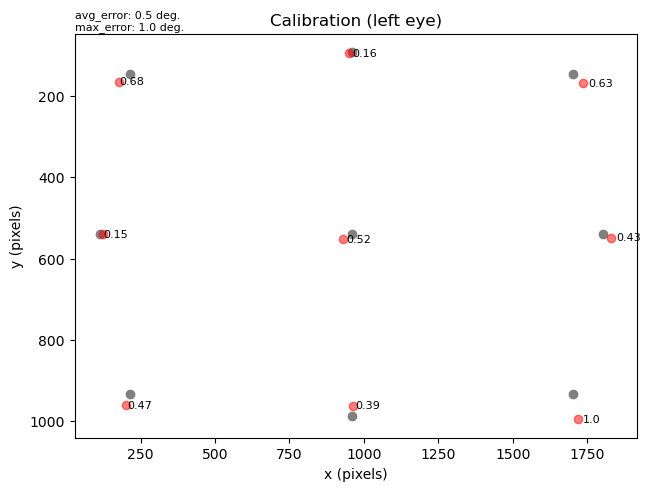

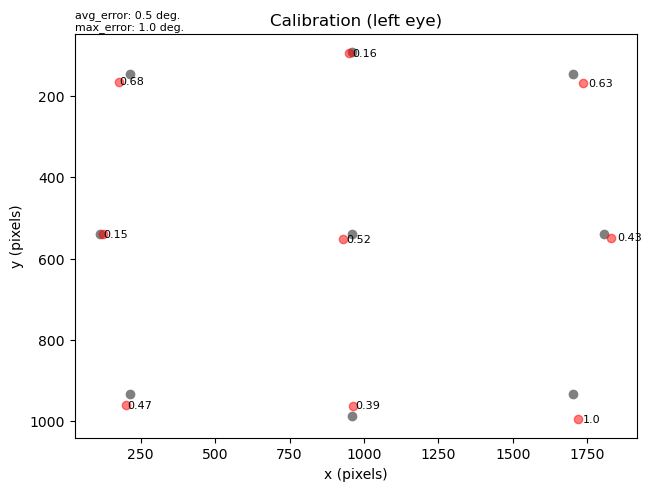

In [5]:
first_cal.plot()

## Plot the raw eye-tracking data

Let's plot the raw eye-tracking data. We'll pass a custom `dict` into
the scalings argument to make the eyegaze channel traces legible when plotting,
since this file contains pixel position data (as opposed to eye angles,
which are reported in radians).

In [6]:
raw_et.plot(scalings=dict(eyegaze=1e3))

Using qt as 2D backend.


## Handling blink artifacts

Naturally, there are blinks in our data, which occur within ``"BAD_blink"``
annotations. During blink periods, eyegaze coordinates are not reported, and pupil
size data are ``0``. We don't want these blink artifacts biasing our analysis, so we
have two options: Drop the blink periods from our data during epoching, or interpolate
the missing data during the blink periods. For this tutorial, let's interpolate the
blink samples. We'll pass ``(0.05, 0.2)`` to
:func:`~mne.preprocessing.eyetracking.interpolate_blinks`, expanding the interpolation
window 50 ms before and 200 ms after the blink, so that the noisy data surrounding
the blink is also interpolated.


In [7]:
mne.preprocessing.eyetracking.interpolate_blinks(raw_et, buffer=(0.05, 0.2))

Interpolating missing data during blinks...
Removing 'BAD_' from BAD_blink.


<RawEyelink | 001_2023_07_12_11_15.asc, 6 x 279593 (559.2 s), ~12.8 MB, data loaded>

.. important:: By default, :func:`~mne.preprocessing.eyetracking.interpolate_blinks`,
          will only interpolate blinks in pupil channels. Passing
          ``interpolate_gaze=True`` will also interpolate the blink periods of the
          eyegaze channels. Be aware, however, that eye movements can occur
          during blinks which makes the gaze data less suitable for interpolation.

In [8]:
raw_et.plot(scalings=dict(eyegaze=1e3))

## Extract common stimulus events from the data

In this experiment, a photodiode attached to the display screen was connected to both
the EEG and eye-tracking systems. The photodiode was triggered by the the light flash
stimuli, causing a signal to be sent to both systems simultaneously, signifying the
onset of the flash. The photodiode signal was recorded as a digital input channel in
the EEG and eye-tracking data. MNE loads these data as a :term:`stim channel`.

We'll extract the flash event onsets from both the EEG and eye-tracking data, as they
are necessary for aligning the data from the two recordings.

## Create the dataframe with temporal values

In [9]:
data_raw=raw_et.get_data(return_times=True)
timestamps=data_raw[1].reshape(len(data_raw[1]),1)
data_raw_values=data_raw[0].T
data_rew_time=np.append(data_raw_values,timestamps,axis=1)
col_n=raw_et.ch_names
col_n.append('time')
data_pd=pd.DataFrame(data_rew_time,
                     columns=col_n
                    )




### Create dataframe for annotations

In [10]:
raw_et.annotations.description
# raw_et.annotations.onset
annotations_pd=pd.DataFrame({'time':raw_et.annotations.onset,
                             'label': raw_et.annotations.description})

### Cut all data by annotations of interest

In [11]:
# pupil_pd_frame=final_df
import sys
from IPython.display import display
display(include=True)
sys.path.append('../../')
sys.path.append('../')
import importlib 
import commons as cm
from pyeyemo import pupillometry2_0_commons as pc 
importlib.reload(pc)


event_initial=annotations_pd['label'].values[0]
event_final=annotations_pd['label'].values[-1]

initial_anotation,_,_=cm.extract_annotations_timestamps(event_initial,'label',annotations_pd)
end_anotation=annotations_pd.iloc[-1]
display(initial_anotation)
display(end_anotation)

pupil_pd_frame=cm.filter_rows_by_temporal_values(
         dataframe=data_pd,
         time_column='time',
         ini_value=initial_anotation['time'].values[0],
         end_value=end_anotation['time']
         )

,time,label
0,0.11,Obj0150_Asset0070.tif


time          559.084
label    blank_screen
Name: 586, dtype: object

In [12]:
%matplotlib qt
filter_events=annotations_pd['label'].str.contains('.tif') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')| annotations_pd['label'].str.contains('image_offset')

fig,ax=pc.plot_signal_with_events(signal_df=pupil_pd_frame,
                           annotattion_df=annotations_pd[filter_events],
                           time_col='time',
                           signal_col='pupil_left')
# ax.set_title(f'raw data for subject: {subject}')

# fig.savefig(f'figures/{subject}_Raw.png', dpi=300)

Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
def create_transtion_matrix(data_pd:pd.DataFrame):
    """Function to create transtion matrix from data segmented by annotation

    Args:
        data_pd (pd.DataFrame): pandas dataframe of interest
    """


lets pick a sample annotation

In [24]:
event_initial

'Obj0150_Asset0070.tif'

In [25]:
filter_events=annotations_pd['label'].str.contains('.tif') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
annotations_pd=annotations_pd[filter_events]
event_initial='Obj0150_Asset0070.tif'

initial_anotation,end_anotation,_=cm.extract_annotations_timestamps(event_initial,'label',annotations_pd)
display(initial_anotation)
display(end_anotation)

pupil_pd_frame=cm.filter_rows_by_temporal_values(
         dataframe=data_pd,
         time_column='time',
         tion['time'].values[0],
         end_value=end_anotation['time']
         )




,time,label
0,0.11,Obj0150_Asset0070.tif


time                     7.973
label    Obj0131_Asset0048.tif
Name: 5, dtype: object

In [27]:
raw_et.info

<Info | 7 non-empty values
 bads: []
 ch_names: xpos_left, ypos_left, pupil_left, xpos_right, ypos_right, ...
 chs: 4 Eye-tracking (Gaze position), 2 Eye-tracking (Pupil size)
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2023-07-12 00:20:15 UTC
 nchan: 6
 projs: []
 sfreq: 500.0 Hz
>

Fist create a matrix of the resolution of the tv.

In [123]:
b_matrix=np.zeros([1086,1926])

lets also round the cordinates.

In [124]:
left_eye_pos=pupil_pd_frame[['xpos_left','ypos_left']].round().dropna().values

In [125]:
left_eye_pos[0]

array([958., 552.])

In [134]:
for row, coord in enumerate(left_eye_pos):
    x=int(left_eye_pos[row][0])
    y=int(left_eye_pos[row][1])
    print(x)
    print(y)
    b_matrix[y,x]+=1

958
552
957
552
955
551
956
551
956
551
956
551
956
551
956
549
956
550
955
551
956
551
958
551
956
550
954
549
954
549
954
549
954
547
952
547
952
548
953
549
954
550
954
549
954
550
954
551
955
551
955
551
955
551
955
550
955
550
955
549
956
550
956
551
956
551
956
551
956
551
956
551
956
552
957
554
956
554
955
553
955
553
954
555
954
556
954
555
954
555
955
557
954
557
953
556
952
555
952
556
952
557
953
556
953
554
953
554
953
555
953
558
953
558
952
558
950
558
951
557
952
556
951
556
950
554
950
554
950
553
950
552
950
552
948
552
947
552
947
552
945
549
944
548
945
548
946
548
948
548
948
548
948
549
947
548
947
548
946
549
947
550
949
552
950
553
952
554
952
554
950
554
950
554
950
556
950
557
950
556
950
556
950
557
950
557
950
557
951
557
951
557
951
557
952
555
952
555
954
556
954
556
954
556
954
553
954
551
953
552
953
551
953
549
953
548
951
548
950
547
951
547
952
547
951
547
950
546
950
547
952
548
952
548
953
550
956
553
956
554
955
555
955
555
956
555
956
557
956
557


In [137]:
%matplotlib qt
from matplotlib import pyplot as plt
fig,ax=plt.subplots()
ax.imshow(b_matrix)

plt.show()

In [138]:
np.any(b_matrix>1)

True

In [ ]:
fig,ax=plt.subplots()
plt.plot(left_eye_pos[0])

array([958., 552.])